In [1]:
Alpha_Name = "5_Input_20220110_10d_ret_StandardScale_MinMax_10"
start_date = "2020-01-01"
end_date = "2020-06-01"

In [2]:
import time
import os
from Research.backtest.bt import BTDaily
import matplotlib.pyplot as plt
from Research.feature.ft import FeatureAnalysis
import Research.utils.namespace as namespace
import Research.utils.normalization as norm
from Platform.database.mysql import MysqlAPI
from Platform.utils.persistence import convert_to_standard_daily_feature_csv, convert_to_standard_daily_feature_par
from Platform.config.mysql_info import FACTOR_LIB_MYSQL_TIO
import DataAPI
from os import walk
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from progressbar import ProgressBar
from tqdm import tqdm
import multiprocessing as mp
import sys
sys.path.append("/home/wuwenjun/jupyter_code/Shannon/AlphaNet/packages/")
model_path = "/home/wuwenjun/Alpha_Factor/" + Alpha_Name + "/" + "%s_%s" %(start_date,end_date) + "/"
if os.path.exists(model_path) == False:
    os.makedirs(model_path)
    print(model_path)

In [3]:
from AlphaNet.Data import DataLoader
trainloader = DataLoader()
trainloader.load_data_from_file(alpha_name = Alpha_Name,end_date = start_date)

Loading the configuration from /home/ShareFolder/lgc/Modules/Research/config/feature_bt_template


  3%|▎         | 35/1219 [00:00<00:04, 286.79it/s]

Loading the configuration from /home/ShareFolder/lgc/Modules/Research/config/feature_bt_template


100%|██████████| 1219/1219 [00:30<00:00, 40.54it/s]


0         1            2         3  \
timestamp           ticker                                              
2015-02-16 09:30:00 000001  0.000064 -0.038558  3954.352065 -0.014480   
                    000002  0.000147  0.135621  5523.931352 -0.033847   
                    000004  0.000093 -0.003361   -18.869629 -0.019579   
                    000005  0.000000  0.000000     0.000000  0.000000   
                    000006  0.000035  0.054798  2741.562408 -0.009933   
...                              ...       ...          ...       ...   
2019-12-31 09:30:00 688366  0.000073 -0.002688    22.559362 -0.016287   
                    688368  0.000197 -0.010143   -26.907990 -0.032727   
                    688369  0.000015 -0.008861    84.007717 -0.032206   
                    688388  0.000037 -0.001228    78.998641 -0.007192   
                    688389  0.000027 -0.002629     6.048070 -0.015823   

                                   4             5         6             7  \
timestamp           ticker                                                   
2015-02-16 09:30:00 000001 -0.153531  -2626.705689 -0.017612  1.415203e+07   
                    000002 -0.583065 -11505.304621 -0.048414  8.801691e+07   
                    000004 -0.011733   -121.588925 -0.039625  6.284071e+03   
                    000005  0.000000      0.000000  0.000000  0.000000e+00   
                    000006  0.008375    430.094542 -0.002161  1.746874e+06   
...                              ...           ...       ...           ...   
2019-12-31 09:30:00 688366 -0.021921    -70.007276 -0.041304  7.920580e+03   
                    688368 -0.012189    -57.497162 -0.052928  2.288874e+03   
                    688369 -0.008649    -19.593120 -0.012468  6.057487e+03   
                    688388 -0.003517    -91.809291 -0.025993  3.661133e+03   
                    688389 -0.000241     -2.246640 -0.004988  3.053870e+03   

                                     8             9  ...       111       112  \
timestamp           ticker                            ...                       
2015-02-16 09:30:00 000001   13.814661  1.150742e+05  ...  0.345175  0.023481   
                    000002  121.464693  2.913541e+06  ...  0.085346 -0.009313   
                    000004    1.512995  1.306707e+04  ...  0.081493  0.038451   
                    000005    0.000000  0.000000e+00  ... -1.000000  0.000000   
                    000006    0.897457 -3.758064e+04  ...  0.088571  0.000000   
...                                ...           ...  ...       ...       ...   
2019-12-31 09:30:00 688366    2.309137  1.129469e+04  ... -0.150452 -0.035167   
                    688368    2.688252  7.848888e+03  ...  1.141902  0.113985   
                    688369    0.313709 -3.432590e+03  ...  0.344850 -0.018097   
                    688388    1.455787  1.702078e+04  ...  4.525981  0.209164   
                    688389    0.238123  2.053975e+03  ...  0.125396  0.011139   

                                 113        114       115       116  \
timestamp           ticker                                            
2015-02-16 09:30:00 000001  0.031142  -1.301542  0.014472 -0.012360   
                    000002 -0.004410  -2.271306  0.020087 -0.022228   
                    000004 -0.009981  -1.736879  0.011924 -0.014008   
                    000005 -1.000000  -1.000000  0.000000  0.000000   
                    000006  0.060849  -2.261014  0.013070 -0.012106   
...                              ...        ...       ...       ...   
2019-12-31 09:30:00 688366 -0.119583   2.143160  0.016155 -0.008964   
                    688368 -0.023913   1.428267  0.034565 -0.034247   
                    688369 -0.242743 -16.035785  0.019045 -0.011697   
                    688388  0.212289   4.499188  0.026055 -0.035712   
                    688389 -0.359154  -1.307557  0.018120 -0.016364   

                                    117           118       119    target  
timestamp       

In [4]:
train_loader = trainloader.to_torch_DataLoader(sequence = 3,shuffle=True)
trainloader.shape

torch.Size([3796142, 3, 40])

In [5]:
from AlphaNet.Models import AlphaNet_LSTM_V1
from AlphaNet import Model_Loader
import torch.optim as optim
LR = 0.001
epoch_num = 10
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
loss_function = nn.MSELoss()
model = AlphaNet_LSTM_V1(40, 64)
optimizer = optim.Adam(model.parameters(), lr=LR)
model_loader = Model_Loader(model = model,device=device)
print(model_loader.model)

AlphaNet_LSTM_V1(
  (batch): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(40, 64, num_layers=5, batch_first=True, bidirectional=True)
  (batch2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (out): Linear(in_features=128, out_features=1, bias=True)
)


  0%|          | 0/10 [00:00<?, ?it/s]

Learning Rate is : 0.001


 10%|█         | 1/10 [00:44<06:38, 44.32s/it]

Epoch:  1  loss:  3.874028560466887


 20%|██        | 2/10 [01:27<05:49, 43.65s/it]

Epoch:  2  loss:  2.9144621657628407


 30%|███       | 3/10 [02:12<05:08, 44.07s/it]

Epoch:  3  loss:  2.7261795394297477


 40%|████      | 4/10 [02:55<04:21, 43.63s/it]

Epoch:  4  loss:  2.5952897686440397


 50%|█████     | 5/10 [03:37<03:35, 43.05s/it]

Epoch:  5  loss:  2.500565280908006


 60%|██████    | 6/10 [04:25<02:59, 44.98s/it]

Epoch:  6  loss:  2.426739438775419


 70%|███████   | 7/10 [05:11<02:15, 45.19s/it]

Epoch:  7  loss:  2.3664433531569786


 80%|████████  | 8/10 [06:07<01:37, 48.60s/it]

Epoch:  8  loss:  2.316070926133896


 90%|█████████ | 9/10 [06:56<00:48, 48.86s/it]

Epoch:  9  loss:  2.2729446713186046


100%|██████████| 10/10 [07:56<00:00, 47.65s/it]

Epoch:  10  loss:  2.2357231055175455


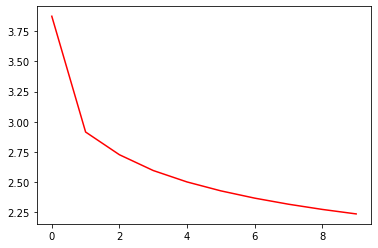

In [6]:
model = model_loader.fit_transform(train_loader,optimizer,loss_function,epoch_num,save_path = model_path)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=LR)
model = model_loader.transform(optimizer = optimizer, epoch_num = 10, method="best")

  0%|          | 0/10 [00:00<?, ?it/s]

Learning Rate is : 0.001


 10%|█         | 1/10 [00:47<07:10, 47.85s/it]

Epoch:  1  loss:  2.2013892532246286


 20%|██        | 2/10 [01:41<06:50, 51.34s/it]

Epoch:  2  loss:  2.1707950418318003


 30%|███       | 3/10 [02:30<05:51, 50.15s/it]

Epoch:  3  loss:  2.1430859226527406


 40%|████      | 4/10 [03:16<04:50, 48.49s/it]

Epoch:  4  loss:  2.1178447445209567


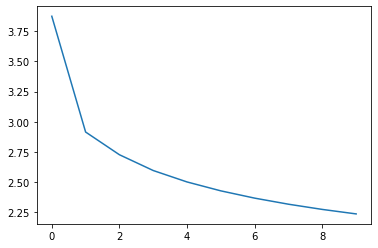

In [7]:
plt.plot(model_loader.loss_list)

In [8]:
testloader = DataLoader()
testloader.load_data_from_file(alpha_name = Alpha_Name,start_date = start_date,end_date = end_date)
test_loader = testloader.to_torch_DataLoader(sequence = 3,shuffle=False)
pred = model_loader.pred(test_loader)

100%|██████████| 98/98 [00:01<00:00, 53.93it/s]


In [9]:
final = pd.concat([testloader.target.reset_index(),pred],axis=1)
final.rename(columns={0:Alpha_Name,'ticker': 'symbol'},inplace=True)
final

,timestamp,symbol,target,5_Input_20220110_10d_ret_StandardScale_MinMax_10
0,2020-01-02 09:30:00,000001,-5.551395,-3.861034
1,2020-01-02 09:30:00,000002,-6.203258,-6.676930
2,2020-01-02 09:30:00,000004,-5.390784,-5.391490
3,2020-01-02 09:30:00,000005,-5.142255,-4.757258
4,2020-01-02 09:30:00,000006,-5.327572,-4.430594
...,...,...,...,...
369026,2020-06-01 09:30:00,688388,-4.510971,-5.906500
369027,2020-06-01 09:30:00,688389,-3.960987,-6.994064
369028,2020-06-01 09:30:00,688396,-4.365947,-5.560849
369029,2020-06-01 09:30:00,688398,-4.135321,-6.718587


In [10]:
final.to_parquet(model_path + "result.par")